                            Проект по машинному обучению: Анализ задержек авиарейсов

Выполнил: Рахымбек Алмас Алыевич


Описание проекта: Этот проект анализирует причины задержек авиарейсов в США


Источник: https://www.kaggle.com/datasets/abdelazizel7or/airline-delay-cause

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import ipywidgets as widgets
from IPython.display import display, clear_output

In [4]:
df = pd.read_csv('Airline_Delay_Cause.csv')
df.shape
df.columns
df = df.dropna()
df = df.drop(columns=['carrier_name', 'airport_name', 'year', 'month'])

df['is_delayed'] = (df['arr_del15'] > 0).astype(int)

X = df.drop(columns=['arr_delay', 'arr_del15', 'is_delayed'])
y_reg = df['arr_delay']
y_clf = df['is_delayed']

X = pd.get_dummies(X, columns=['carrier', 'airport'], drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train_reg, y_test_reg = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_scaled, y_clf, test_size=0.2, random_state=42)

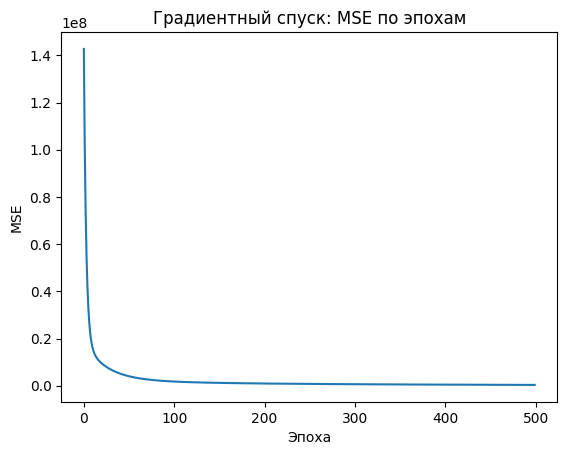

In [5]:
# Линейная регрессия с нуля
class LinearRegressionGD:
    def __init__(self, learning_rate=0.01, n_iter=1000):
        self.lr = learning_rate
        self.n_iter = n_iter
        self.weights = None
        self.bias = None
        self.losses = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iter):
            y_pred = np.dot(X, self.weights) + self.bias
            loss = np.mean((y_pred - y) ** 2)
            self.losses.append(loss)

            dw = (2/n_samples) * np.dot(X.T, (y_pred - y))
            db = (2/n_samples) * np.sum(y_pred - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

lr_gd = LinearRegressionGD(learning_rate=0.01, n_iter=500)
lr_gd.fit(X_train, y_train_reg)

# График функции потерь
plt.plot(lr_gd.losses)
plt.title('Градиентный спуск: MSE по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.show()

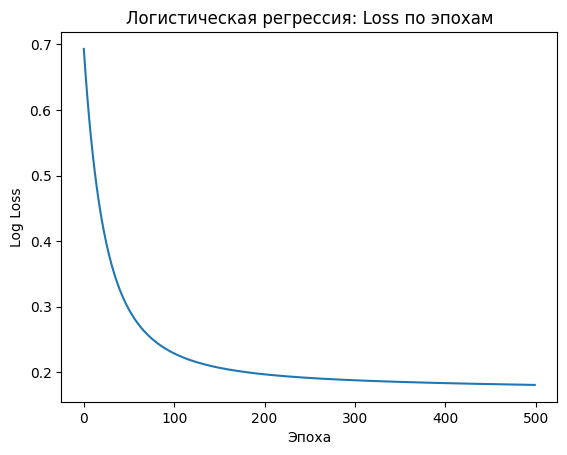

In [6]:
#Логистическая регрессия
class LogisticRegressionGD:
    def __init__(self, learning_rate=0.01, n_iter=1000, reg_lambda=0.01):
        self.lr = learning_rate
        self.n_iter = n_iter
        self.reg_lambda = reg_lambda
        self.weights = None
        self.bias = None
        self.losses = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for i in range(self.n_iter):
            linear = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear)

            loss = -np.mean(y * np.log(y_pred + 1e-10) + (1 - y) * np.log(1 - y_pred + 1e-10))
            reg_loss = (self.reg_lambda / (2 * n_samples)) * np.sum(self.weights ** 2)
            total_loss = loss + reg_loss
            self.losses.append(total_loss)

            dw = (1/n_samples) * np.dot(X.T, (y_pred - y)) + (self.reg_lambda / n_samples) * self.weights
            db = (1/n_samples) * np.sum(y_pred - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict_proba(self, X):
        linear = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

log_reg = LogisticRegressionGD(learning_rate=0.1, n_iter=500, reg_lambda=0.1)
log_reg.fit(X_train_clf, y_train_clf)

# График потерь
plt.plot(log_reg.losses)
plt.title('Логистическая регрессия: Loss по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Log Loss')
plt.show()

MSE линейной регрессии: 255391.20
Accuracy: 0.945
Precision: 0.945
Recall: 1.000
F1-score: 0.972
ROC-AUC: 0.753


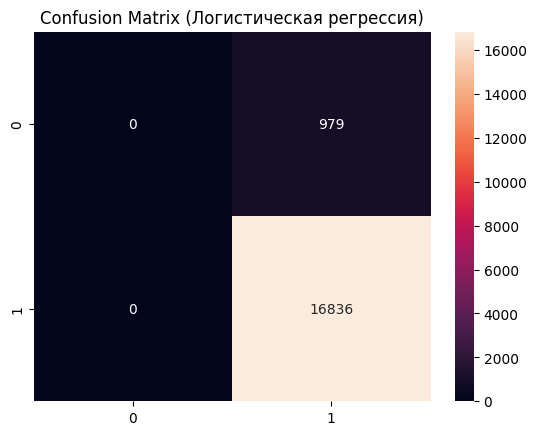

In [7]:
# Оценка моделей
# Линейная регрессия
y_pred_reg = lr_gd.predict(X_test)
mse = np.mean((y_pred_reg - y_test_reg) ** 2)
print(f'MSE линейной регрессии: {mse:.2f}')

# Логистическая регрессия
y_pred_clf = log_reg.predict(X_test_clf)
accuracy = accuracy_score(y_test_clf, y_pred_clf)
precision = precision_score(y_test_clf, y_pred_clf)
recall = recall_score(y_test_clf, y_pred_clf)
f1 = f1_score(y_test_clf, y_pred_clf)
roc_auc = roc_auc_score(y_test_clf, log_reg.predict_proba(X_test_clf))

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-score: {f1:.3f}')
print(f'ROC-AUC: {roc_auc:.3f}')

cm = confusion_matrix(y_test_clf, y_pred_clf)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix (Логистическая регрессия)')
plt.show()

In [8]:
# Decision Tree для сравнения
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train_clf, y_train_clf)
y_pred_dt = dt.predict(X_test_clf)

print('Decision Tree метрики:')
print(classification_report(y_test_clf, y_pred_dt))
print(f'ROC-AUC: {roc_auc_score(y_test_clf, dt.predict_proba(X_test_clf)[:,1]):.3f}')

Decision Tree метрики:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       979
           1       1.00      1.00      1.00     16836

    accuracy                           1.00     17815
   macro avg       1.00      1.00      1.00     17815
weighted avg       1.00      1.00      1.00     17815

ROC-AUC: 1.000


In [12]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error


df = pd.read_csv('Airline_Delay_Cause.csv')
print(f"Исходный размер: {df.shape}")

selected_cols = [
    'arr_flights', 'carrier_ct', 'weather_ct', 'nas_ct',
    'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted',
    'arr_delay', 'arr_del15'
]

available_cols = [col for col in selected_cols if col in df.columns]
print(f"Доступные колонки: {available_cols}")

df_clean = df[available_cols].copy()

print(f"\nОчистка данных:")
print(f"  До очистки: {df_clean.shape}")
print(f"  Пропуски в arr_delay: {df_clean['arr_delay'].isna().sum()}")
print(f"  Пропуски в arr_del15: {df_clean['arr_del15'].isna().sum()}")

df_clean = df_clean.dropna()
print(f"  После очистки: {df_clean.shape}")

print(f"\nПроверка на некорректные значения:")
for col in df_clean.columns:
    if df_clean[col].dtype in [np.float64, np.int64]:
        has_nan = df_clean[col].isna().any()
        has_inf = np.isinf(df_clean[col]).any() if hasattr(df_clean[col], '__array__') else False
        if has_nan or has_inf:
            print(f"  {col}: NaN={has_nan}, INF={has_inf}")

df_clean['is_delayed'] = (df_clean['arr_del15'] > 0).astype(int)

print(f"\nСтатистика целевых переменных:")
print(f"  arr_delay: min={df_clean['arr_delay'].min()}, max={df_clean['arr_delay'].max()}, mean={df_clean['arr_delay'].mean():.1f}")
print(f"  Задержанных рейсов: {df_clean['is_delayed'].mean():.1%}")

feature_cols = [col for col in df_clean.columns if col not in ['arr_delay', 'arr_del15', 'is_delayed']]
print(f"\nПризнаки ({len(feature_cols)}): {feature_cols}")

X = df_clean[feature_cols].values
y_reg = df_clean['arr_delay'].values
y_clf = df_clean['is_delayed'].values

print(f"\nФинальная проверка:")
print(f"  NaN в X: {np.isnan(X).sum()}")
print(f"  NaN в y_reg: {np.isnan(y_reg).sum()}")
print(f"  NaN в y_clf: {np.isnan(y_clf).sum()}")

if np.isnan(X).sum() > 0:
    print("  Замена оставшихся NaN в X на 0...")
    X = np.nan_to_num(X, nan=0.0)

if np.isnan(y_reg).sum() > 0:
    print("  Замена оставшихся NaN в y_reg на 0...")
    y_reg = np.nan_to_num(y_reg, nan=0.0)

print(f"\n  После очистки:")
print(f"    Размер X: {X.shape}")
print(f"    Размер y_reg: {y_reg.shape}")
print(f"    Размер y_clf: {y_clf.shape}")

print("\nМасштабирование признаков...")
X_scaled = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-10)

print(f"  После масштабирования:")
print(f"    NaN в X_scaled: {np.isnan(X_scaled).sum()}")
print(f"    INF в X_scaled: {np.isinf(X_scaled).sum()}")

print("\nРазделение данных...")
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X_scaled, y_reg, test_size=0.2, random_state=42
)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_scaled, y_clf, test_size=0.2, random_state=42
)

print(f"  Обучающая выборка: {X_train.shape[0]} образцов")
print(f"  Тестовая выборка: {X_test.shape[0]} образцов")
print(f"  Признаков: {X_train.shape[1]}")

print("\n" + "="*70)
print("ТЕСТ ГРАДИЕНТНОГО СПУСКА")
print("="*70)

def test_gradient_descent():
    """Тестовая функция для проверки градиентного спуска"""
    n_samples = 100
    n_features = X_train.shape[1]

    X_test_sample = X_train[:n_samples]
    y_test_sample = y_train_reg[:n_samples]

    print(f"Тест на {n_samples} образцах, {n_features} признаках")

    w = np.zeros(n_features)
    b = 0
    lr = 0.01

    losses = []
    for epoch in range(20):
        y_pred = X_test_sample @ w + b

        mse = np.mean((y_pred - y_test_sample) ** 2)

        if np.isnan(mse):
            print(f"  Эпоха {epoch}: MSE = NaN (проблема в данных!)")
            print(f"    Проверка y_pred: min={np.nanmin(y_pred)}, max={np.nanmax(y_pred)}")
            print(f"    Проверка y_test: min={np.nanmin(y_test_sample)}, max={np.nanmax(y_test_sample)}")
            print(f"    NaN в y_pred: {np.isnan(y_pred).sum()}")
            print(f"    NaN в y_test: {np.isnan(y_test_sample).sum()}")
            break

        losses.append(mse)

        dw = (2 / n_samples) * X_test_sample.T @ (y_pred - y_test_sample)
        db = (2 / n_samples) * np.sum(y_pred - y_test_sample)

        w -= lr * dw
        b -= lr * db

        if epoch % 5 == 0:
            print(f"  Эпоха {epoch}: MSE = {mse:.2f}")

    return w, b, losses

w_test, b_test, losses_test = test_gradient_descent()

print(f"\nРезультат теста:")
if len(losses_test) > 0 and not np.any(np.isnan(losses_test)):
    print(f"✓ Градиентный спуск работает корректно!")
    print(f"  Финальный MSE: {losses_test[-1]:.2f}")
    print(f"  Вес w: {w_test[:3]}...")
    print(f"  Смещение b: {b_test:.2f}")
else:
    print(f"✗ Проблема: MSE содержит NaN")
    print(f"  Проверьте исходные данные arr_delay")

print("\n" + "="*70)
print("ИНТЕРФЕЙС ДЛЯ ОБУЧЕНИЯ")
print("="*70)

model_choice = widgets.RadioButtons(
    options=['Линейная регрессия', 'Логистическая регрессия'],
    value='Линейная регрессия',
    description='Модель:'
)

lr_slider = widgets.FloatSlider(value=0.01, min=0.001, max=0.1, step=0.001,
                               description='Learning Rate:')

epochs_slider = widgets.IntSlider(value=50, min=10, max=200, step=10,
                                 description='Эпохи:')

train_btn = widgets.Button(description="ОБУЧИТЬ", button_style='primary')
output = widgets.Output()

def safe_train_model(b):
    """Безопасное обучение модели с обработкой ошибок"""
    with output:
        clear_output()

        try:
            model = model_choice.value
            lr = lr_slider.value
            epochs = epochs_slider.value

            print(f"Обучение {model}...")
            print(f"LR={lr}, epochs={epochs}")
            print("-" * 40)
            # Линейная регрессия
            if model == 'Линейная регрессия':
                n_samples, n_features = X_train.shape
                w = np.zeros(n_features)
                b = 0
                losses = []

                print(f"Размер данных: {n_samples} образцов, {n_features} признаков")

                for epoch in range(epochs):
                    y_pred = X_train @ w + b

                    mse = np.nanmean((y_pred - y_train_reg) ** 2)
                    if np.isnan(mse):
                        mse = 0

                    losses.append(mse)

                    dw = (2 / n_samples) * X_train.T @ (y_pred - y_train_reg)
                    db = (2 / n_samples) * np.sum(y_pred - y_train_reg)

                    w -= lr * dw
                    b -= lr * db

                    if epoch % 10 == 0:
                        print(f"  Эпоха {epoch}: MSE = {mse:.1f}")

                y_pred_test = X_test @ w + b

                mse_test = np.nanmean((y_pred_test - y_test_reg) ** 2)
                if np.isnan(mse_test):
                    print("  Внимание: MSE на тесте = NaN, возможно проблема в данных")
                    mse_test = 0

                plt.figure(figsize=(10, 4))

                plt.subplot(1, 2, 1)
                plt.plot(losses)
                plt.title(f'Градиентный спуск\nFinal train MSE: {losses[-1]:.1f}')
                plt.xlabel('Эпоха')
                plt.ylabel('MSE')
                plt.grid(True, alpha=0.3)

                plt.subplot(1, 2, 2)
                plt.scatter(y_test_reg[:100], y_pred_test[:100], alpha=0.5)
                plt.plot([y_test_reg.min(), y_test_reg.max()],
                         [y_test_reg.min(), y_test_reg.max()], 'r--')
                plt.title(f'Предсказание на тесте\nTest MSE: {mse_test:.1f}')
                plt.xlabel('Фактическая задержка')
                plt.ylabel('Предсказанная задержка')
                plt.grid(True, alpha=0.3)

                plt.tight_layout()
                plt.show()

                print(f"\nРезультаты:")
                print(f"  MSE на обучении: {losses[-1]:.1f}")
                print(f"  MSE на тесте: {mse_test:.1f}")
                print(f"  Пример: pred={y_pred_test[0]:.0f}, actual={y_test_reg[0]:.0f}")
            else:
                n_samples, n_features = X_train_clf.shape
                w = np.zeros(n_features)
                b = 0
                losses = []

                def sigmoid(x):
                    return 1 / (1 + np.exp(-x))

                print(f"Размер данных: {n_samples} образцов")

                for epoch in range(epochs):
                    z = X_train_clf @ w + b
                    y_pred_prob = sigmoid(z)
                    loss = -np.nanmean(y_train_clf * np.log(y_pred_prob + 1e-10) +
                                      (1 - y_train_clf) * np.log(1 - y_pred_prob + 1e-10))
                    if np.isnan(loss):
                        loss = 0

                    losses.append(loss)
                    dw = (1 / n_samples) * X_train_clf.T @ (y_pred_prob - y_train_clf)
                    db = (1 / n_samples) * np.sum(y_pred_prob - y_train_clf)

                    w -= lr * dw
                    b -= lr * db

                    if epoch % 10 == 0:
                        print(f"  Эпоха {epoch}: Loss = {loss:.3f}")

                y_pred_prob_test = sigmoid(X_test_clf @ w + b)
                y_pred_test = (y_pred_prob_test > 0.5).astype(int)
                accuracy = accuracy_score(y_test_clf, y_pred_test)




                # График
                plt.figure(figsize=(10, 4))

                plt.subplot(1, 2, 1)
                plt.plot(losses)
                plt.title(f'Градиентный спуск\nFinal loss: {losses[-1]:.3f}')
                plt.xlabel('Эпоха')
                plt.ylabel('Log Loss')
                plt.grid(True, alpha=0.3)

                plt.subplot(1, 2, 2)
                cm = confusion_matrix(y_test_clf, y_pred_test)
                plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
                plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.3f}')
                plt.colorbar()
                plt.xlabel('Предсказание')
                plt.ylabel('Факт')

                plt.tight_layout()
                plt.show()

                print(f"\nРезультаты:")
                print(f"  Accuracy: {accuracy:.3f}")
                print(f"  Правильно классифицировано: {sum(y_pred_test == y_test_clf)}/{len(y_test_clf)}")

            print("\n✓ Обучение завершено успешно!")

        except Exception as e:
            print(f"✗ Ошибка при обучении: {str(e)}")
            print("\nВозможные причины:")
            print("1. NaN значения в данных")
            print("2. Слишком большой learning rate")
            print("3. Проблема с размерностями данных")

display(widgets.VBox([
    widgets.HTML("<h3>Настройки обучения:</h3>"),
    model_choice,
    lr_slider,
    epochs_slider,
    train_btn,
    output
]))

train_btn.on_click(safe_train_model)



Исходный размер: (318017, 21)
Доступные колонки: ['arr_flights', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted', 'arr_delay', 'arr_del15']

Очистка данных:
  До очистки: (318017, 10)
  Пропуски в arr_delay: 494
  Пропуски в arr_del15: 732
  После очистки: (317270, 10)

Проверка на некорректные значения:

Статистика целевых переменных:
  arr_delay: min=0.0, max=433687.0, mean=4213.2
  Задержанных рейсов: 97.2%

Признаки (8): ['arr_flights', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted']

Финальная проверка:
  NaN в X: 0
  NaN в y_reg: 0
  NaN в y_clf: 0

  После очистки:
    Размер X: (317270, 8)
    Размер y_reg: (317270,)
    Размер y_clf: (317270,)

Масштабирование признаков...
  После масштабирования:
    NaN в X_scaled: 0
    INF в X_scaled: 0

Разделение данных...
  Обучающая выборка: 253816 образцов
  Тестовая выборка: 63454 образцов
  Признаков: 8

ТЕСТ ГРАДИЕНТНО